In [1]:
from nav2_simple_commander.robot_navigator import BasicNavigator
from geometry_msgs.msg import PoseWithCovarianceStamped
from geometry_msgs.msg import PoseStamped
from rclpy.duration import Duration
import yaml
import rclpy

rclpy.init()
nav = BasicNavigator()

In [2]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

# 지도 이미지 로드
pgm_img = cv2.imread('/home/du/mini_bot/src/pinklab_minibot_robot/minibot_navigation2/maps/baby_map.pgm', cv2.IMREAD_GRAYSCALE)
# PNG로 저장
cv2.imwrite('/home/du/mini_bot/map.png', pgm_img)

True

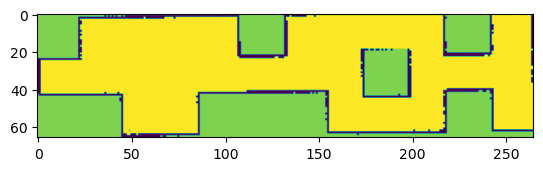

In [3]:
map_img = cv2.imread("/home/du/mini_bot/map.png",cv2.COLOR_BGR2GRAY )
plt.imshow(map_img)

In [4]:
def image_Grid(h, w, img):
    img_height, img_width = img.shape
    grid_size = (h, w)  # 세로, 가로
    
    # 그리드 영역 크기 계산
    cell_height = img_height // grid_size[0]
    cell_width = img_width // grid_size[1]

    
    map_cost = []
    map_col = []
    
    #각각의 그리드 영역에서 흰색 픽셀 비율 계산
    for i in range(grid_size[0]):
        map_col = []
        for j in range(grid_size[1]):
            # 그리드 영역의 범위를 지정하는거고
            cell_top = i * cell_height
            cell_left = j * cell_width
            cell_bottom = cell_top + cell_height
            cell_right = cell_left + cell_width
            
            
            if i == h-1:
                cell_bottom = img_height
                
            
            # 그 맵의 모든 픽셀을 가져와서
            cell = img[cell_top:cell_bottom, cell_left:cell_right]

            wall = 0
            load = 0
            for row in range(len(cell)):
                for col in range(len(cell[0])):
                
                    if cell[row][col] <= 210:
                        wall += 1;
                    else:
                        load += 1
            
                
            if load > wall:
                map_col.append(0)
            else:
                map_col.append(1)
        
        map_cost.append(map_col)
                
    return map_cost, cell_height, cell_width

In [5]:
my_map, cell_height, cell_width = image_Grid(3, 12, map_img)
for i in my_map:
    print(i)

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]


In [6]:
# YAML 파일 경로 
# 나중에 유저에게 맵 위치만 입력을 받게할 수 있을 
yaml_path = "/home/du/mini_bot/src/pinklab_minibot_robot/minibot_navigation2/maps/baby_map.yaml"

# YAML 파일 읽기
with open(yaml_path, "r") as stream:
    yaml_data = yaml.safe_load(stream)

# resolution 값 가져오기
resolution = yaml_data["resolution"]

print(resolution)

0.05


In [7]:
class Astar:
    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position

    def heuristic(self, node, goal, D=1, D2=2 ** 0.5):  # Diagonal Distance
        dx = abs(node.position[0] - goal.position[0])
        dy = abs(node.position[1] - goal.position[1])
        return D * (dx + dy)


    def aStar(self, maze, start, end):
        # startNode와 endNode 초기화
        startNode = Astar(None, start)
        endNode = Astar(None, end)

        # openList, closedList 초기화
        openList = []
        closedList = []

        # openList에 시작 노드 추가
        openList.append(startNode)

        # endNode를 찾을 때까지 실행
        while openList:

            # 현재 노드 지정
            currentNode = openList[0]
            currentIdx = 0

            # 이미 같은 노드가 openList에 있고, f 값이 더 크면
            # currentNode를 openList안에 있는 값으로 교체
            for index, item in enumerate(openList):
                if item.f < currentNode.f:
                    currentNode = item
                    currentIdx = index

            # openList에서 제거하고 closedList에 추가
            openList.pop(currentIdx)
            closedList.append(currentNode)

            # 현재 노드가 목적지면 current.position 추가하고
            # current의 부모로 이동
            if currentNode == endNode:
                path = []
                current = currentNode
                while current is not None:
                    # maze 길을 표시하려면 주석 해제
                    x, y = current.position
                    maze[x][y] = 2
                    path.append(current.position)
                    current = current.parent
                return path[::-1]  # reverse

            children = []
            # 인접한 xy좌표 전부
            for newPosition in [(0, -1), (0, 1), (-1, 0), (1, 0)]:

                # 노드 위치 업데이트
                nodePosition = (
                    currentNode.position[0] + newPosition[0],  # X
                    currentNode.position[1] + newPosition[1])  # Y
                    
                # 미로 maze index 범위 안에 있어야함
                within_range_criteria = [
                    nodePosition[0] > (len(maze) - 1),
                    nodePosition[0] < 0,
                    nodePosition[1] > (len(maze[len(maze) - 1]) - 1),
                    nodePosition[1] < 0,
                ]

                if any(within_range_criteria):  # 하나라도 true면 범위 밖임
                    continue

                # 장애물이 있으면 다른 위치 불러오기
                if maze[nodePosition[0]][nodePosition[1]] != 0:
                    continue

                new_node = Astar(currentNode, nodePosition)
                children.append(new_node)

            # 자식들 모두 loop
            for child in children:

                # 자식이 closedList에 있으면 continue
                if child in closedList:
                    continue

                # f, g, h값 업데이트
                child.g = currentNode.g + 1
                child.h = ((child.position[0] - endNode.position[0]) **
                        2) + ((child.position[1] - endNode.position[1]) ** 2)
                # child.h = heuristic(child, endNode) 다른 휴리스틱
                # print("position:", child.position) 거리 추정 값 보기
                # print("from child to goal:", child.h)
                
                child.f = child.g + child.h

                # 자식이 openList에 있으고, g값이 더 크면 continue
                if len([openNode for openNode in openList
                        if child == openNode and child.g > openNode.g]) > 0:
                    continue
                        
                openList.append(child)

    def run(self, maze, start, end):
        path = self.aStar(maze, start, end)
        return maze, path

In [8]:
#그리드 한 칸의 크기와 resolution의 곱이 결국 이동한 m값이 됩니다.
garo_m = resolution * cell_width
sero_m = resolution * cell_height

print(garo_m, sero_m)

1.1 1.1


In [9]:
my_map_coordinate = []
my_map_layer = []

cor_x = -1.1  #1.1씩 더하세요
cor_y = 2.2  #1.1씩 빼세요.
    
for i in range(len(my_map)):
    cor_x = -1.1
    cor_y = cor_y - 1.1
    for j in range(len(my_map[0])):
        cor_x = cor_x + 1.1
        if my_map[i][j] == 1:
            my_map_layer.append(None)
        elif my_map[i][j] == 0:
            goal = PoseStamped()
            goal.header.frame_id = 'map'
            goal.header.stamp = nav.get_clock().now().to_msg()
            goal.pose.position.x = cor_x
            goal.pose.position.y = cor_y
            goal.pose.position.z = 0.006378173828125
            goal.pose.orientation.x = 0.0
            goal.pose.orientation.y = 0.0
            goal.pose.orientation.z = 0.0
            goal.pose.orientation.w = 1.0
            my_map_layer.append(goal)

    my_map_coordinate.append(my_map_layer)
    my_map_layer = []

In [10]:
print("맵입니다.")
for i in my_map:
    print(i)
print()

temp_map = my_map
make_route = Astar()
start = (0, 1)
end = (1,11 )
result, path = make_route.run(temp_map , start, end)

print("경로 생성 맵입니다. 숫자 2는 경로입니다.")
for i in result:
    print(i)


맵입니다.
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]

경로 생성 맵입니다. 숫자 2는 경로입니다.
[1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 0]
[0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2]
[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]


In [11]:
print(path)

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (1, 5), (1, 6), (1, 7), (0, 7), (0, 8), (0, 9), (1, 9), (1, 10), (1, 11)]


In [12]:
def go_my_robot(my_map_coordinate, start, end):
    my_map, cell_height, cell_width = image_Grid(3, 12, map_img)

    make_route = Astar()
    result, path = make_route.run(my_map , start, end)

    print("경로 생성 맵입니다. 숫자 2는 경로입니다.")
    for i in result:
        print(i)
        
    if path == None:
        print("이동할 수 없는 지점으로 이동을 명령하고 있습니다.")
        return
    else:
        path_0 = path[0]
        path = path[1:]

    for route in path:
        print("명령을 이수합니다." + str(route) + "좌표로 이동합니다." )
        
        
        
        #북쪽
        if route[1] - path_0[1] == 1:
            my_map_coordinate[route[0]][route[1]].pose.orientation.x = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.y = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.z = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.w = 1.0
        
        #남쪽
        elif route[1] - path_0[1] == -1:
            my_map_coordinate[route[0]][route[1]].pose.orientation.x = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.y = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.z = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.w = -1.0
        
        # 서쪽
        elif route[0] - path_0[0] == -1:
            my_map_coordinate[route[0]][route[1]].pose.orientation.x = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.y = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.z = 0.7
            my_map_coordinate[route[0]][route[1]].pose.orientation.w = 0.7
            
        # 동쪽
        elif route[0] - path_0[0] == 1:
            my_map_coordinate[route[0]][route[1]].pose.orientation.x = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.y = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.z = -0.7
            my_map_coordinate[route[0]][route[1]].pose.orientation.w = 0.7
            
            
        nav.goToPose(my_map_coordinate[route[0]][route[1]])

        i=0
        while not nav.isTaskComplete():
            i = i+1
            feedback = nav.getFeedback()
            if feedback and i % 5 == 0:
                print("Distance remaining : " + str(feedback.distance_remaining) + " m")
                if feedback.distance_remaining > 0.1:
                    pass
                else:
                    print("Distance remaining : " + str(feedback.distance_remaining) + " m")
                    nav.cancelTask()
                    print("명령을 이수했습니다.")


        print(str(route) + "좌표로 이동했습니다." )
        print()
        
        path_0 = route
                        #nav.cancelTask()
            
        #if Duration.from_msg(feedback.navigation_time) > Duration(seconds = 10.0):
            #nav.cancelTask()

In [13]:
go_my_robot(my_map_coordinate, (1,0), (1, 11))

경로 생성 맵입니다. 숫자 2는 경로입니다.
[1, 0, 0, 0, 0, 1, 0, 2, 2, 2, 1, 0]
[2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2]
[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]
명령을 이수합니다.(1, 1)좌표로 이동합니다.


[INFO] [1678964370.495999350] [basic_navigator]: Navigating to goal: 1.1 0.0...


Distance remaining : 1.000145435333252 m
Distance remaining : 0.900145411491394 m
Distance remaining : 0.750145435333252 m
Distance remaining : 0.6501453518867493 m
Distance remaining : 0.5001452565193176 m
Distance remaining : 0.35013413429260254 m
Distance remaining : 0.24142135679721832 m
(1, 1)좌표로 이동했습니다.

명령을 이수합니다.(1, 2)좌표로 이동합니다.


[INFO] [1678964374.058808189] [basic_navigator]: Navigating to goal: 2.2 0.0...


Distance remaining : 1.2176300287246704 m
Distance remaining : 1.1156654357910156 m
Distance remaining : 0.9681254625320435 m
Distance remaining : 0.863779604434967 m
Distance remaining : 0.7118167281150818 m
Distance remaining : 0.611335039138794 m
Distance remaining : 0.46213996410369873 m
Distance remaining : 0.31143826246261597 m
Distance remaining : 0.22071067988872528 m
Distance remaining : 0.22071067988872528 m
(1, 2)좌표로 이동했습니다.

명령을 이수합니다.(1, 3)좌표로 이동합니다.


[INFO] [1678964379.470866195] [basic_navigator]: Navigating to goal: 3.3000000000000003 0.0...


Distance remaining : 1.203735589981079 m
Distance remaining : 1.1037355661392212 m
Distance remaining : 1.0037355422973633 m
Distance remaining : 0.8537355661392212 m
Distance remaining : 0.7537356019020081 m
Distance remaining : 0.6537355184555054 m
Distance remaining : 0.5037360191345215 m
Distance remaining : 0.40372368693351746 m
Distance remaining : 0.27071067690849304 m
(1, 3)좌표로 이동했습니다.

명령을 이수합니다.(1, 4)좌표로 이동합니다.


[INFO] [1678964384.133169056] [basic_navigator]: Navigating to goal: 4.4 0.0...


Distance remaining : 1.269262671470642 m
Distance remaining : 1.1192222833633423 m
Distance remaining : 0.9689810276031494 m
Distance remaining : 0.868004322052002 m
Distance remaining : 0.7188162207603455 m
Distance remaining : 0.6150277853012085 m
Distance remaining : 0.4623383581638336 m
Distance remaining : 0.36184802651405334 m
(1, 4)좌표로 이동했습니다.

명령을 이수합니다.(1, 5)좌표로 이동합니다.


[INFO] [1678964388.496821184] [basic_navigator]: Navigating to goal: 5.5 0.0...


Distance remaining : 1.2040873765945435 m
Distance remaining : 1.103386402130127 m
Distance remaining : 0.949999988079071 m
Distance remaining : 0.8500000238418579 m
Distance remaining : 0.699999988079071 m
Distance remaining : 0.550000011920929 m
Distance remaining : 0.45000001788139343 m
Distance remaining : 0.30000001192092896 m
(1, 5)좌표로 이동했습니다.

명령을 이수합니다.(1, 6)좌표로 이동합니다.


[INFO] [1678964392.760256432] [basic_navigator]: Navigating to goal: 6.6 0.0...


Distance remaining : 1.2000000476837158 m
Distance remaining : 1.100000023841858 m
Distance remaining : 1.0 m
Distance remaining : 0.800000011920929 m
Distance remaining : 0.699999988079071 m
Distance remaining : 0.6000000238418579 m
Distance remaining : 0.45000001788139343 m
Distance remaining : 0.3499999940395355 m
Distance remaining : 0.25 m
(1, 6)좌표로 이동했습니다.

명령을 이수합니다.(1, 7)좌표로 이동합니다.


[INFO] [1678964397.323315984] [basic_navigator]: Navigating to goal: 7.699999999999999 0.0...


Distance remaining : 1.300183653831482 m
Distance remaining : 1.190245270729065 m
Distance remaining : 1.0350117683410645 m
Distance remaining : 0.9257162809371948 m
Distance remaining : 0.7751067876815796 m
Distance remaining : 0.671160101890564 m
Distance remaining : 0.5175870060920715 m
Distance remaining : 0.4175044298171997 m
Distance remaining : 0.34142136573791504 m
(1, 7)좌표로 이동했습니다.

명령을 이수합니다.(0, 7)좌표로 이동합니다.


[INFO] [1678964402.338156599] [basic_navigator]: Navigating to goal: 7.699999999999999 1.1...


Distance remaining : 1.0946898460388184 m
Distance remaining : 1.0446889400482178 m
Distance remaining : 0.961188793182373 m
Distance remaining : 0.8111886978149414 m
Distance remaining : 0.7067457437515259 m
Distance remaining : 0.5644144415855408 m
Distance remaining : 0.44142135977745056 m
Distance remaining : 0.320710688829422 m
(0, 7)좌표로 이동했습니다.

명령을 이수합니다.(0, 8)좌표로 이동합니다.


[INFO] [1678964406.562899688] [basic_navigator]: Navigating to goal: 8.799999999999999 1.1...


Distance remaining : 1.11272394657135 m
Distance remaining : 1.023896336555481 m
Distance remaining : 1.002363920211792 m
Distance remaining : 0.85067218542099 m
Distance remaining : 0.75 m
Distance remaining : 0.6000000238418579 m
Distance remaining : 0.5 m
Distance remaining : 0.4000000059604645 m
Distance remaining : 0.25 m
(0, 8)좌표로 이동했습니다.

명령을 이수합니다.(0, 9)좌표로 이동합니다.


[INFO] [1678964411.125106067] [basic_navigator]: Navigating to goal: 9.899999999999999 1.1...


Distance remaining : 1.25 m
Distance remaining : 1.100000023841858 m
Distance remaining : 1.0 m
Distance remaining : 0.9000000357627869 m
Distance remaining : 0.7508445978164673 m
Distance remaining : 0.6501954793930054 m
Distance remaining : 0.5515410304069519 m
Distance remaining : 0.4001964032649994 m
Distance remaining : 0.30000001192092896 m
(0, 9)좌표로 이동했습니다.

명령을 이수합니다.(1, 9)좌표로 이동합니다.


[INFO] [1678964415.887494369] [basic_navigator]: Navigating to goal: 9.899999999999999 0.0...


Distance remaining : 1.0374420881271362 m
Distance remaining : 0.9777308106422424 m
Distance remaining : 0.9521269798278809 m
Distance remaining : 0.8521268963813782 m
Distance remaining : 0.7515400052070618 m
Distance remaining : 0.6001954674720764 m
Distance remaining : 0.5025424957275391 m
Distance remaining : 0.35043004155158997 m
(1, 9)좌표로 이동했습니다.

명령을 이수합니다.(1, 10)좌표로 이동합니다.


[INFO] [1678964420.399922884] [basic_navigator]: Navigating to goal: 10.999999999999998 0.0...


Distance remaining : 1.0892597436904907 m
Distance remaining : 1.0286881923675537 m
Distance remaining : 1.0037355422973633 m
Distance remaining : 0.9037355780601501 m
Distance remaining : 0.7508445978164673 m
Distance remaining : 0.6501954793930054 m
Distance remaining : 0.5008456110954285 m
Distance remaining : 0.4001964032649994 m
Distance remaining : 0.25 m
(1, 10)좌표로 이동했습니다.

명령을 이수합니다.(1, 11)좌표로 이동합니다.


[INFO] [1678964425.062492306] [basic_navigator]: Navigating to goal: 12.099999999999998 0.0...


Distance remaining : 1.2691305875778198 m
Distance remaining : 1.1145601272583008 m
Distance remaining : 1.0192979574203491 m
Distance remaining : 0.8639878034591675 m
Distance remaining : 0.7643155455589294 m
Distance remaining : 0.6130481362342834 m
Distance remaining : 0.5128222107887268 m
Distance remaining : 0.3625413775444031 m
Distance remaining : 0.2914213538169861 m
Distance remaining : 0.19142135977745056 m
(1, 11)좌표로 이동했습니다.



명령을 이수합니다.(1, 1)좌표로 이동합니다.


[INFO] [1678941971.843662073] [basic_navigator]: Navigating to goal: 1.1 0.0...


Distance remaining : 1.4021315574645996 m
Distance remaining : 1.4021315574645996 m
Distance remaining : 1.4021315574645996 m
Distance remaining : 1.4021315574645996 m
Distance remaining : 1.3314892053604126 m
Distance remaining : 1.190299153327942 m
Distance remaining : 1.0460014343261719 m
Distance remaining : 0.9862084984779358 m
Distance remaining : 0.8222092986106873 m
Distance remaining : 0.7033778429031372 m
Distance remaining : 0.5742974877357483 m
Distance remaining : 0.4568812847137451 m
Distance remaining : 0.3621320426464081 m
Distance remaining : 0.24142135679721832 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.24142135679721832 m
Distance remaining : 0.24142135679721832 m
(1, 1)좌표로 이동했습니다.

명령을 이수합니다.(1, 2)좌표로 이동합니다.


[INFO] [1678941983.058964248] [basic_navigator]: Navigating to goal: 2.2 0.0...


Distance remaining : 0.8617819547653198 m
Distance remaining : 0.7117815017700195 m
Distance remaining : 0.6117828488349915 m
Distance remaining : 0.4617120623588562 m
Distance remaining : 0.3914213478565216 m
Distance remaining : 0.24142135679721832 m
(1, 2)좌표로 이동했습니다.

명령을 이수합니다.(0, 2)좌표로 이동합니다.


[INFO] [1678941986.171355237] [basic_navigator]: Navigating to goal: 2.2 1.1...


Distance remaining : 1.0830092430114746 m
Distance remaining : 1.0830092430114746 m
Distance remaining : 0.9611887335777283 m
Distance remaining : 0.8611887097358704 m
Distance remaining : 0.75 m
Distance remaining : 0.6500000357627869 m
Distance remaining : 0.5030601620674133 m
Distance remaining : 0.35297691822052 m
Distance remaining : 0.25 m
Distance remaining : 0.20000000298023224 m
Distance remaining : 0.20000000298023224 m
Distance remaining : 0.20000000298023224 m
Distance remaining : 0.20000000298023224 m
Distance remaining : 0.20000000298023224 m
(0, 2)좌표로 이동했습니다.



In [ ]:
#오리엔테이션 정리
# 북쪽
0, 0, 0, 1

# 남쪽
0, 0, 0, -1

# 서쪽
0, 0, 0.7, 0.7

# 동쪽
0, 0, -0.7, 0.7